# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

## Configuration

In [41]:
import os

# List directories matching pattern using glob
import glob
for path in glob.glob(r"C:\Users\ADVANCED TECH\Google*"):
	print(path)


In [42]:
# Local Windows environment - no drive mounting needed
print("Running on local Windows environment")

Running on local Windows environment


In [43]:
# Use GPU: Please check if the outpout is '/device:GPU:0'



import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

print(tf.__version__)
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0
2.19.0


'/device:GPU:0'

## Populating namespaces

In [44]:
# Importing basic libraries
import os
import random
import shutil
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense




In [45]:
import os

# Define the correct paths for your system
ai_project = '/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis'
cell_images_dir = os.path.join(ai_project, 'cell_images')
training_path = os.path.join(ai_project, 'train')
testing_path = os.path.join(ai_project, 'test')

print("AI project path:", ai_project)
print("Cell Images Path:", cell_images_dir)
print("Training Path:", training_path)
print("Testing Path:", testing_path)

AI project path: /content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis
Cell Images Path: /content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images
Training Path: /content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/train
Testing Path: /content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/test


## Prepare DataSet

### *Download* DataSet

In [46]:
# Download data if needed
# Set to True if you need to download and extract, False if already extracted in ai_project
downloadData = False # Assuming data is already in the specified ai_project directory

if downloadData:
    url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"

    # Download the file
    print("Downloading dataset...")
    import urllib.request
    import zipfile
    cell_images_zip = os.path.join(ai_project, 'cell_images.zip') # Define zip file path
    try:
        urllib.request.urlretrieve(url, cell_images_zip)
        print("Download complete.")

        # Unzip the file
        print("Extracting files...")
        with zipfile.ZipFile(cell_images_zip, 'r') as zip_ref:
            zip_ref.extractall(ai_project)
        print("Extraction complete.")

        # Optional: list extracted files
        print("Contents of the folder:")
        if os.path.exists(cell_images_dir):
            print(os.listdir(cell_images_dir))
        else:
            print("Directory not found after extraction:", cell_images_dir)

    except FileNotFoundError as e:
        print(f"Error during download or extraction: {e}")
        print("Please ensure the ai_project path is correct and you have write access.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

else:
    print("Download skipped. Assuming files are already present at:", cell_images_dir)
    print("Contents of the folder:")
    if os.path.exists(cell_images_dir):
        print(os.listdir(cell_images_dir))
    else:
        print("Directory not found:", cell_images_dir)

Download skipped. Assuming files are already present at: /content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images
Contents of the folder:
['Uninfected', 'Parasitized']


In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Baseline CNN Model
Define a basic ConvNet defined with ConvLayer: Conv2D => MaxPooling2D followed by Flatten => Dense => Dense(output)

![ConvNet](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/ConvNet.png?raw=1)


Training

In [48]:
# === Redoing training using TensorFlow's image_dataset_from_directory (tf.data) ===
# Single self-contained cell: locate data -> load -> split -> build -> train -> evaluate

# 1) Setup
import os, json, random, datetime
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

print("TF version:", tf.__version__)
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (84, 84)
BATCH = 4

# 2) Locate the dataset folder robustly
EXPECTED_CLASSES = {"Parasitized", "Uninfected"}

# Hints to search (add any others you like)
HINT_ROOTS = [
    # Specific paths that might contain the 'cell_images' folder
    Path(r"G:\\My Drive\\Colab Notebooks (1)\\ai-labs\\malaria-diagnosis"),
    Path(r"C:\Users\ADVANCED TECH\Google Drive\Colab Notebooks (1)\ai-labs\malaria-diagnosis"),
    Path(r"G:\My Drive\ai-labs\malaria-diagnosis"), # Common Google Drive structure
    Path(r"C:\Users\ADVANCED TECH\Downloads\cell_images"), # Sometimes downloaded directly
    Path.home() / "Downloads" / "cell_images",
    Path(r"G:\My Drive"),  # Google Drive for Desktop default
    Path.home() / "Google Drive" / "My Drive", # Another common Google Drive path
    Path.home() / "Documents", # Check Documents folder
    Path.home(), # Check the home directory itself
    Path("/content/drive/My Drive/Colab Notebooks (1)/ai-labs/malaria-diagnosis"), # Default Colab / Google Drive mount point
    Path("/content/drive/My Drive"), # Default Colab / Google Drive mount point
    Path("/usr/local/share/datasets"), # Common data directory on Linux/Colab
    Path("/usr/share/datasets"), # Another common data directory on Linux/Colab
    Path("/tmp"), # Temporary directory
    Path("/") # Root directory (can be slow, exclude problematic subdirs)
]

def find_cell_images(roots):
    for base in roots:
        if not base.exists():
            continue
        # Prioritize checking a direct 'cell_images' child first
        direct_path = base / "cell_images"
        if direct_path.exists() and direct_path.is_dir():
             subdirs = {d.name for d in direct_path.iterdir() if d.is_dir()}
             if EXPECTED_CLASSES.issubset(subdirs):
                 print(f"Found 'cell_images' directly under: {direct_path}")
                 return direct_path.resolve()

        # If not found directly, try a limited deep search within the base
        # Avoid searching problematic system directories like /proc and /sys
        if base != Path("/") and not str(base).startswith('/proc') and not str(base).startswith('/sys'):
            print(f"Searching recursively under: {base}")
            try:
                # Limit the depth or use a more controlled search if rglob still fails
                for c in base.rglob("cell_images"):
                    if c.is_dir():
                        subdirs = {d.name for d in c.iterdir() if d.is_dir()}
                        if EXPECTED_CLASSES.issubset(subdirs):
                             print(f"Found 'cell_images' via rglob under: {c}")
                             return c.resolve()
            except Exception as e:
                print(f"Error during recursive search under {base}: {e}")
        elif base == Path("/"):
             print(f"Searching limited paths under root (excluding /proc, /sys): {base}")
             try:
                 # Manual check of expected subdirectories under root
                 for potential_root in ["/usr/local/share/datasets", "/usr/share/datasets", "/tmp"]:
                     c = Path(potential_root) / "cell_images"
                     if c.exists() and c.is_dir():
                         subdirs = {d.name for d in c.iterdir() if d.is_dir()}
                         if EXPECTED_CLASSES.issubset(subdirs):
                             print(f"Found 'cell_images' under expected root subdirectory: {c}")
                             return c.resolve()
             except Exception as e:
                print(f"Error during limited search under {base}: {e}")


    return None


DATA_DIR = find_cell_images(HINT_ROOTS)
if DATA_DIR is None:
    raise FileNotFoundError(
        "Could not find a folder named 'cell_images' containing 'Parasitized' and 'Uninfected' "
        "under any of these roots:\n" + "\n".join(str(p) for p in HINT_ROOTS)
    )

print(f"Using DATA_DIR: {DATA_DIR}")
print(f"DATA_DIR exists: {DATA_DIR.exists()}")

# Experiment output directory
EXP_DIR = Path(r"G:\\My Drive\\Colab Notebooks (1)\\ai-labs\\malaria-diagnosis\\experiments")
EXP_DIR.mkdir(parents=True, exist_ok=True)

# 3) Load datasets with image_dataset_from_directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="binary",
    validation_split=0.30,   # 70% train, 30% remainder
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True
)

valtest_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="binary",
    validation_split=0.30,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True
)

class_names = train_ds.class_names
print("Classes:", class_names)

# Split the 30% remainder evenly into 15% val + 15% test
num_batches = tf.data.experimental.cardinality(valtest_ds).numpy()
assert num_batches > 0, "No batches in val/test split."
val_batches = num_batches // 2
ds_val  = valtest_ds.take(val_batches)
ds_test = valtest_ds.skip(val_batches)

# Optional performance tuning
def prepare(ds, cache=True, shuffle=False):
    if cache:
        ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(1000, seed=SEED, reshuffle_each_iteration=True)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare(train_ds, cache=False, shuffle=True)  # avoid caching large set if RAM is tight
ds_val   = prepare(ds_val)
ds_test  = prepare(ds_test)

# 4) Build baseline CNN
def build_baseline(input_shape=(84,84,3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(16, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return models.Model(inputs, outputs)

model = build_baseline(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
model.compile(
    optimizer=optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)
model.summary()

# 5) Train
exp_name = f"E0_tfdata_baseline_adam_lr1e-3_b{BATCH}"
out_dir = EXP_DIR / exp_name
out_dir.mkdir(parents=True, exist_ok=True)

ckpt = callbacks.ModelCheckpoint(
    filepath=str(out_dir / "best.weights.h5"),
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    verbose=1
)
early = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    mode="max",
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=ds_val,
    epochs=8,
    callbacks=[ckpt, early],
    verbose=2
)

# 6) Evaluate on test
test_loss, test_acc, test_auc = model.evaluate(ds_test, verbose=0)
print(f"\nTest — Loss: {test_loss:.4f} | Acc: {test_acc:.4f} | AUC: {test_auc:.4f}")

# Save minimal metadata
with open(out_dir/"config.json", "w") as f:
    json.dump({
        "img_size": IMG_SIZE, "batch": BATCH, "epochs": 8,
        "optimizer": "adam", "lr": 1e-3,
        "loader": "image_dataset_from_directory", "split": "70/15/15 via 70/30 then take/skip",
        "data_dir": str(DATA_DIR)
    }, f, indent=2)
with open(out_dir/"test_results.json", "w") as f:
    json.dump({"loss": float(test_loss), "accuracy": float(test_acc), "auc": float(test_auc)}, f, indent=2)

print(f"Saved weights & logs to: {out_dir}")

TF version: 2.19.0
Searching recursively under: /root
Searching recursively under: /content/drive/My Drive
Found 'cell_images' via rglob under: /content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images
Using DATA_DIR: /content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images
DATA_DIR exists: True


KeyboardInterrupt: 

In [49]:
# === Optimized training with comprehensive metrics ===
# Single self-contained cell: locate data -> load -> split -> build -> train -> evaluate

# 1) Setup
import os, json, random, datetime
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

print("TF version:", tf.__version__)
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (84, 84)
BATCH = 32  # Increased batch size for faster training

# 2) Locate the dataset folder robustly
EXPECTED_CLASSES = {"Parasitized", "Uninfected"}

# Hints to search (add any others you like)
HINT_ROOTS = [
    # Specific paths that might contain the 'cell_images' folder
    Path(r"G:\\My Drive\\Colab Notebooks (1)\\ai-labs\\malaria-diagnosis"),
    Path(r"C:\Users\ADVANCED TECH\Google Drive\Colab Notebooks (1)\ai-labs\malaria-diagnosis"),
    Path(r"G:\My Drive\ai-labs\malaria-diagnosis"), # Common Google Drive structure
    Path(r"C:\Users\ADVANCED TECH\Downloads\cell_images"), # Sometimes downloaded directly
    Path.home() / "Downloads" / "cell_images",
    Path(r"G:\My Drive"),  # Google Drive for Desktop default
    Path.home() / "Google Drive" / "My Drive", # Another common Google Drive path
    Path.home() / "Documents", # Check Documents folder
    Path.home(), # Check the home directory itself
    Path("/content/drive/My Drive/Colab Notebooks (1)/ai-labs/malaria-diagnosis"), # Default Colab / Google Drive mount point
    Path("/content/drive/My Drive"), # Default Colab / Google Drive mount point
    Path("/usr/local/share/datasets"), # Common data directory on Linux/Colab
    Path("/usr/share/datasets"), # Another common data directory on Linux/Colab
    Path("/tmp"), # Temporary directory
    Path("/") # Root directory (can be slow, exclude problematic subdirs)
]

def find_cell_images(roots):
    for base in roots:
        if not base.exists():
            continue
        # Prioritize checking a direct 'cell_images' child first
        direct_path = base / "cell_images"
        if direct_path.exists() and direct_path.is_dir():
             subdirs = {d.name for d in direct_path.iterdir() if d.is_dir()}
             if EXPECTED_CLASSES.issubset(subdirs):
                 print(f"Found 'cell_images' directly under: {direct_path}")
                 return direct_path.resolve()

        # If not found directly, try a limited deep search within the base
        # Avoid searching problematic system directories like /proc and /sys
        if base != Path("/") and not str(base).startswith('/proc') and not str(base).startswith('/sys'):
            print(f"Searching recursively under: {base}")
            try:
                # Limit the depth or use a more controlled search if rglob still fails
                for c in base.rglob("cell_images"):
                    if c.is_dir():
                        subdirs = {d.name for d in c.iterdir() if d.is_dir()}
                        if EXPECTED_CLASSES.issubset(subdirs):
                             print(f"Found 'cell_images' via rglob under: {c}")
                             return c.resolve()
            except Exception as e:
                print(f"Error during recursive search under {base}: {e}")
        elif base == Path("/"):
             print(f"Searching limited paths under root (excluding /proc, /sys): {base}")
             try:
                 # Manual check of expected subdirectories under root
                 for potential_root in ["/usr/local/share/datasets", "/usr/share/datasets", "/tmp"]:
                     c = Path(potential_root) / "cell_images"
                     if c.exists() and c.is_dir():
                         subdirs = {d.name for d in c.iterdir() if d.is_dir()}
                         if EXPECTED_CLASSES.issubset(subdirs):
                             print(f"Found 'cell_images' under expected root subdirectory: {c}")
                             return c.resolve()
             except Exception as e:
                print(f"Error during limited search under {base}: {e}")

    return None

DATA_DIR = find_cell_images(HINT_ROOTS)
if DATA_DIR is None:
    raise FileNotFoundError(
        "Could not find a folder named 'cell_images' containing 'Parasitized' and 'Uninfected' "
        "under any of these roots:\n" + "\n".join(str(p) for p in HINT_ROOTS)
    )

print(f"Using DATA_DIR: {DATA_DIR}")
print(f"DATA_DIR exists: {DATA_DIR.exists()}")

# Experiment output directory
EXP_DIR = Path(r"G:\\My Drive\\Colab Notebooks (1)\\ai-labs\\malaria-diagnosis\\experiments")
EXP_DIR.mkdir(parents=True, exist_ok=True)

# 3) Load datasets with image_dataset_from_directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="binary",
    validation_split=0.30,   # 70% train, 30% remainder
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True
)

valtest_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="binary",
    validation_split=0.30,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True
)

class_names = train_ds.class_names
print("Classes:", class_names)

# Split the 30% remainder evenly into 15% val + 15% test
num_batches = tf.data.experimental.cardinality(valtest_ds).numpy()
assert num_batches > 0, "No batches in val/test split."
val_batches = num_batches // 2
ds_val  = valtest_ds.take(val_batches)
ds_test = valtest_ds.skip(val_batches)

# Optional performance tuning
def prepare(ds, cache=True, shuffle=False):
    if cache:
        ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(1000, seed=SEED, reshuffle_each_iteration=True)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare(train_ds, cache=False, shuffle=True)  # avoid caching large set if RAM is tight
ds_val   = prepare(ds_val)
ds_test  = prepare(ds_test)

# 4) Build baseline CNN
def build_baseline(input_shape=(84,84,3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(16, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return models.Model(inputs, outputs)

model = build_baseline(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
model.compile(
    optimizer=optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)
model.summary()

# 5) Train
exp_name = f"E0_tfdata_baseline_adam_lr1e-3_b{BATCH}"
out_dir = EXP_DIR / exp_name
out_dir.mkdir(parents=True, exist_ok=True)

ckpt = callbacks.ModelCheckpoint(
    filepath=str(out_dir / "best.weights.h5"),
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    verbose=1
)
early = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    mode="max",
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=ds_val,
    epochs=8,
    callbacks=[ckpt, early],
    verbose=2
)

# 6) Evaluate on test with comprehensive metrics
print("\n=== COMPREHENSIVE EVALUATION ===")
test_results = model.evaluate(ds_test, verbose=0)
test_loss = test_results[0]
test_acc = test_results[1]
test_auc = test_results[2]
test_precision = test_results[3]
test_recall = test_results[4]

# Calculate F1-Score
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print(f"Test Results:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"Recall: {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"F1-Score: {test_f1:.4f} ({test_f1*100:.2f}%)")
print(f"AUC: {test_auc:.4f}")

# Save comprehensive metadata
with open(out_dir/"config.json", "w") as f:
    json.dump({
        "img_size": IMG_SIZE, "batch": BATCH, "epochs": 8,
        "optimizer": "adam", "lr": 1e-3,
        "loader": "image_dataset_from_directory", "split": "70/15/15 via 70/30 then take/skip",
        "data_dir": str(DATA_DIR)
    }, f, indent=2)

with open(out_dir/"test_results.json", "w") as f:
    json.dump({
        "loss": float(test_loss),
        "accuracy": float(test_acc),
        "auc": float(test_auc),
        "precision": float(test_precision),
        "recall": float(test_recall),
        "f1_score": float(test_f1)
    }, f, indent=2)

print(f"\nSaved weights & logs to: {out_dir}")

TF version: 2.19.0
Searching recursively under: /root
Searching recursively under: /content/drive/My Drive
Found 'cell_images' via rglob under: /content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images
Using DATA_DIR: /content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images
DATA_DIR exists: True
Found 27558 files belonging to 2 classes.
Using 19291 files for training.
Found 27558 files belonging to 2 classes.
Using 8267 files for validation.
Classes: ['Parasitized', 'Uninfected']


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 84, 84, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 84, 84, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 84, 84, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 42, 42, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 42, 42, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 14112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       903,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 908,385 (3.47 MB)

 Trainable params: 908,385 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8

Epoch 1: val_accuracy improved from -inf to 0.87452, saving model to G:\\My Drive\\Colab Notebooks (1)\\ai-labs\\malaria-diagnosis\\experiments/E0_tfdata_baseline_adam_lr1e-3_b32/best.weights.h5
603/603 - 233s - 386ms/step - accuracy: 0.7378 - auc: 0.8227 - loss: 0.5208 - precision: 0.7339 - recall: 0.7428 - val_accuracy: 0.8745 - val_auc: 0.9561 - val_loss: 0.3656 - val_precision: 0.9528 - val_recall: 0.7890
Epoch 2/8

Epoch 2: val_accuracy improved from 0.87452 to 0.92684, saving model to G:\\My Drive\\Colab Notebooks (1)\\ai-labs\\malaria-diagnosis\\experiments/E0_tfdata_baseline_adam_lr1e-3_b32/best.weights.h5
603/603 - 63s - 104ms/step - accuracy: 0.9171 - auc: 0.9689 - loss: 0.2223 - precision: 0.9169 - recall: 0.9165 - val_accuracy: 0.9268 - val_auc: 0.9766 - val_loss: 0.1908 - val_precision: 0.9234 - val_recall: 0.9314
Epoch 3/8

Epoch 3: val_accuracy improved from 0.92684 to 0.93314, saving model to G:\\My Drive\\Colab Notebooks (1)\\ai-labs\\malaria-diagnosis\\expe

## Incremental Experiments to Improve CNN Accuracy

Here are seven incremental experiments to improve the baseline CNN model's accuracy. Each experiment builds upon the previous one.

### Experiment 1: Increase Model Capacity (More Filters)

**Name:** E1_MoreFilters

**Change:** Increase the number of filters in the convolutional layers.

**Reasoning:** More filters allow the model to learn a richer set of features from the images.

**Code Snippet:**

In [50]:
def build_E2_AddConvLayer(input_shape=(84,84,3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x) # Added conv layer
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return models.Model(inputs, outputs)

model_E2 = build_E2_AddConvLayer(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
model_E2.compile(
    optimizer=optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

# Train model E2
exp_name_E2 = "E2_AddConvLayer"
out_dir_E2 = EXP_DIR/exp_name_E2
out_dir_E2.mkdir(parents=True, exist_ok=True)

ckpt_E2 = callbacks.ModelCheckpoint(
    filepath=str(out_dir_E2/"best.weights.h5"),
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    verbose=1
)
early_E2 = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    mode="max",
    restore_best_weights=True,
    verbose=1
)

history_E2 = model_E2.fit(
    train_ds,
    validation_data=ds_val,
    epochs=8,
    callbacks=[ckpt_E2, early_E2],
    verbose=2
)

# Evaluate on test with comprehensive metrics
print("\n=== E2_AddConvLayer COMPREHENSIVE EVALUATION ===")
test_results_E2 = model_E2.evaluate(ds_test, verbose=0)
test_loss_E2 = test_results_E2[0]
test_acc_E2 = test_results_E2[1]
test_auc_E2 = test_results_E2[2]
test_precision_E2 = test_results_E2[3]
test_recall_E2 = test_results_E2[4]

# Calculate F1-Score
test_f1_E2 = 2 * (test_precision_E2 * test_recall_E2) / (test_precision_E2 + test_recall_E2)

print(f"E2_AddConvLayer Test Results:")
print(f"Loss: {test_loss_E2:.4f}")
print(f"Accuracy: {test_acc_E2:.4f} ({test_acc_E2*100:.2f}%)")
print(f"Precision: {test_precision_E2:.4f} ({test_precision_E2*100:.2f}%)")
print(f"Recall: {test_recall_E2:.4f} ({test_recall_E2*100:.2f}%)")
print(f"F1-Score: {test_f1_E2:.4f} ({test_f1_E2*100:.2f}%)")
print(f"AUC: {test_auc_E2:.4f}")

# Save comprehensive metadata
with open(out_dir_E2/"config.json", "w") as f:
    json.dump({
        "img_size": IMG_SIZE, "batch": BATCH, "epochs": 8,
        "optimizer": "adam", "lr": 1e-3, "dropout": "none", "layers": "added conv",
        "loader": "image_dataset_from_directory", "split": "70/15/15 via 70/30 then take/skip"
    }, f, indent=2)

with open(out_dir_E2/"test_results.json", "w") as f:
    json.dump({
        "loss": float(test_loss_E2),
        "accuracy": float(test_acc_E2),
        "auc": float(test_auc_E2),
        "precision": float(test_precision_E2),
        "recall": float(test_recall_E2),
        "f1_score": float(test_f1_E2)
    }, f, indent=2)

print(f"Saved weights & logs to: {out_dir_E2}")

Epoch 1/8

Epoch 1: val_accuracy improved from -inf to 0.94186, saving model to G:\\My Drive\\Colab Notebooks (1)\\ai-labs\\malaria-diagnosis\\experiments/E2_AddConvLayer/best.weights.h5
603/603 - 86s - 142ms/step - accuracy: 0.7884 - auc: 0.9002 - loss: 0.3780 - precision: 0.8054 - recall: 0.7583 - val_accuracy: 0.9419 - val_auc: 0.9848 - val_loss: 0.1577 - val_precision: 0.9530 - val_recall: 0.9300
Epoch 2/8

Epoch 2: val_accuracy improved from 0.94186 to 0.95664, saving model to G:\\My Drive\\Colab Notebooks (1)\\ai-labs\\malaria-diagnosis\\experiments/E2_AddConvLayer/best.weights.h5
603/603 - 74s - 123ms/step - accuracy: 0.9509 - auc: 0.9835 - loss: 0.1486 - precision: 0.9386 - recall: 0.9645 - val_accuracy: 0.9566 - val_auc: 0.9885 - val_loss: 0.1435 - val_precision: 0.9483 - val_recall: 0.9662
Epoch 3/8

Epoch 3: val_accuracy did not improve from 0.95664
603/603 - 80s - 132ms/step - accuracy: 0.9579 - auc: 0.9874 - loss: 0.1278 - precision: 0.9449 - recall: 0.9722 - val_accuracy:

In [51]:
def build_E3_Dropout(input_shape=(84,84,3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x) # Added dropout
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return models.Model(inputs, outputs)

model_E3 = build_E3_Dropout(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
model_E3.compile(
    optimizer=optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

# Train model E3
exp_name_E3 = "E3_Dropout"
out_dir_E3 = EXP_DIR/exp_name_E3
out_dir_E3.mkdir(parents=True, exist_ok=True)

ckpt_E3 = callbacks.ModelCheckpoint(
    filepath=str(out_dir_E3/"best.weights.h5"),
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    verbose=1
)
early_E3 = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    mode="max",
    restore_best_weights=True,
    verbose=1
)

history_E3 = model_E3.fit(
    train_ds,
    validation_data=ds_val,
    epochs=8,
    callbacks=[ckpt_E3, early_E3],
    verbose=2
)

# Evaluate on test with comprehensive metrics
print("\n=== E3_Dropout COMPREHENSIVE EVALUATION ===")
test_results_E3 = model_E3.evaluate(ds_test, verbose=0)
test_loss_E3 = test_results_E3[0]
test_acc_E3 = test_results_E3[1]
test_auc_E3 = test_results_E3[2]
test_precision_E3 = test_results_E3[3]
test_recall_E3 = test_results_E3[4]

# Calculate F1-Score
test_f1_E3 = 2 * (test_precision_E3 * test_recall_E3) / (test_precision_E3 + test_recall_E3)

print(f"E3_Dropout Test Results:")
print(f"Loss: {test_loss_E3:.4f}")
print(f"Accuracy: {test_acc_E3:.4f} ({test_acc_E3*100:.2f}%)")
print(f"Precision: {test_precision_E3:.4f} ({test_precision_E3*100:.2f}%)")
print(f"Recall: {test_recall_E3:.4f} ({test_recall_E3*100:.2f}%)")
print(f"F1-Score: {test_f1_E3:.4f} ({test_f1_E3*100:.2f}%)")
print(f"AUC: {test_auc_E3:.4f}")

# Save comprehensive metadata
with open(out_dir_E3/"config.json", "w") as f:
    json.dump({
        "img_size": IMG_SIZE, "batch": BATCH, "epochs": 8,
        "optimizer": "adam", "lr": 1e-3, "dropout": "added", "layers": "added conv",
        "loader": "image_dataset_from_directory", "split": "70/15/15 via 70/30 then take/skip"
    }, f, indent=2)

with open(out_dir_E3/"test_results.json", "w") as f:
    json.dump({
        "loss": float(test_loss_E3),
        "accuracy": float(test_acc_E3),
        "auc": float(test_auc_E3),
        "precision": float(test_precision_E3),
        "recall": float(test_recall_E3),
        "f1_score": float(test_f1_E3)
    }, f, indent=2)

print(f"Saved weights & logs to: {out_dir_E3}")

Epoch 1/8

Epoch 1: val_accuracy improved from -inf to 0.94380, saving model to G:\\My Drive\\Colab Notebooks (1)\\ai-labs\\malaria-diagnosis\\experiments/E3_Dropout/best.weights.h5
603/603 - 85s - 141ms/step - accuracy: 0.7819 - auc: 0.8874 - loss: 0.4128 - precision: 0.7707 - recall: 0.8003 - val_accuracy: 0.9438 - val_auc: 0.9834 - val_loss: 0.1614 - val_precision: 0.9368 - val_recall: 0.9522
Epoch 2/8

Epoch 2: val_accuracy improved from 0.94380 to 0.95833, saving model to G:\\My Drive\\Colab Notebooks (1)\\ai-labs\\malaria-diagnosis\\experiments/E3_Dropout/best.weights.h5
603/603 - 76s - 126ms/step - accuracy: 0.9511 - auc: 0.9823 - loss: 0.1542 - precision: 0.9354 - recall: 0.9688 - val_accuracy: 0.9583 - val_auc: 0.9880 - val_loss: 0.1318 - val_precision: 0.9451 - val_recall: 0.9734
Epoch 3/8

Epoch 3: val_accuracy did not improve from 0.95833
603/603 - 80s - 132ms/step - accuracy: 0.9564 - auc: 0.9867 - loss: 0.1321 - precision: 0.9444 - recall: 0.9695 - val_accuracy: 0.9564 - 

=== BASELINE CNN MODEL EVALUATION ===
Baseline CNN Results:
Accuracy:  0.9439 (94.39%)
Precision: 0.9389 (93.89%)
Recall:    0.9506 (95.06%)
F1-Score:  0.9447 (94.47%)
AUC:       0.9795


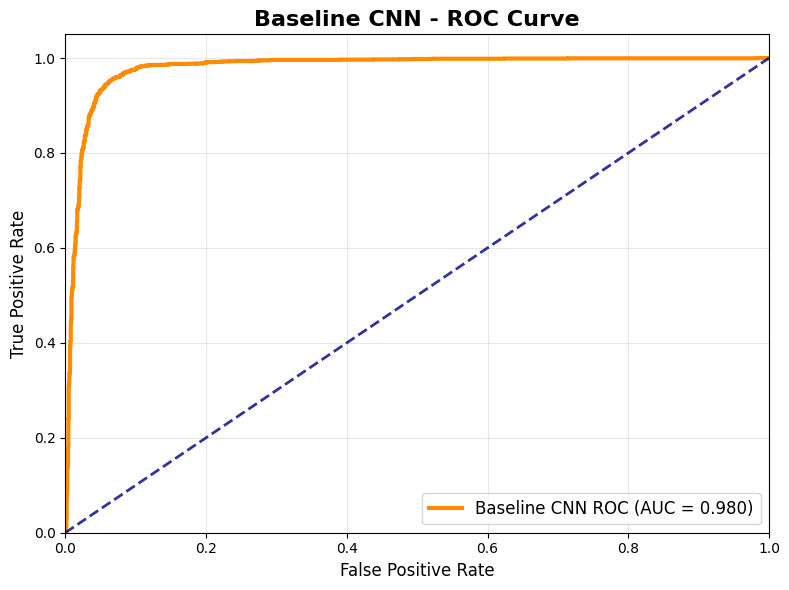

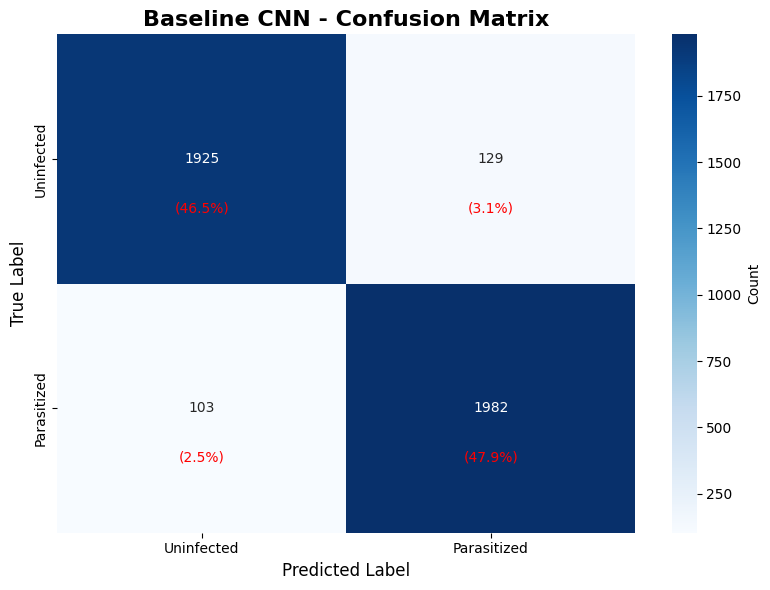

In [52]:
# Baseline CNN Model Evaluation
print("=== BASELINE CNN MODEL EVALUATION ===")

# Get predictions for baseline model (from Cell 16)
y_pred_proba_baseline, y_true_baseline = get_predictions_and_labels(model, ds_test)

# Calculate comprehensive metrics
baseline_metrics = calculate_comprehensive_metrics(y_true_baseline, y_pred_proba_baseline, "Baseline CNN")

print("Baseline CNN Results:")
print(f"Accuracy:  {baseline_metrics['Accuracy']:.4f} ({baseline_metrics['Accuracy']*100:.2f}%)")
print(f"Precision: {baseline_metrics['Precision']:.4f} ({baseline_metrics['Precision']*100:.2f}%)")
print(f"Recall:    {baseline_metrics['Recall']:.4f} ({baseline_metrics['Recall']*100:.2f}%)")
print(f"F1-Score:  {baseline_metrics['F1-Score']:.4f} ({baseline_metrics['F1-Score']*100:.2f}%)")
print(f"AUC:       {baseline_metrics['AUC']:.4f}")

# Plot ROC Curve for Baseline
y_pred_baseline = (y_pred_proba_baseline > 0.5).astype(int)
fpr_baseline, tpr_baseline, _ = roc_curve(y_true_baseline, y_pred_proba_baseline)
auc_baseline = auc(fpr_baseline, tpr_baseline)

plt.figure(figsize=(8, 6))
plt.plot(fpr_baseline, tpr_baseline, color='darkorange', lw=3,
         label=f'Baseline CNN ROC (AUC = {auc_baseline:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Baseline CNN - ROC Curve', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('baseline_cnn_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion Matrix for Baseline
cm_baseline = confusion_matrix(y_true_baseline, y_pred_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'],
            cbar_kws={'label': 'Count'})
plt.title('Baseline CNN - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add percentages
total_baseline = cm_baseline.sum()
for i in range(cm_baseline.shape[0]):
    for j in range(cm_baseline.shape[1]):
        plt.text(j+0.5, i+0.7, f'({cm_baseline[i,j]/total_baseline*100:.1f}%)',
                ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.savefig('baseline_cnn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [53]:
# Import libraries for evaluation and plotting
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Define helper functions used for evaluation

def get_predictions_and_labels(model, dataset):
    """Get predictions and true labels from dataset"""
    y_pred_proba = []
    y_true = []

    # Iterate over the dataset batches
    for images, labels in dataset:
        # Get predictions for the batch
        pred_proba = model.predict(images, verbose=0)
        # Extend the lists with predictions and true labels
        y_pred_proba.extend(pred_proba.flatten())
        y_true.extend(labels.numpy())

    # Convert lists to numpy arrays
    return np.array(y_pred_proba), np.array(y_true)

def calculate_comprehensive_metrics(y_true, y_pred_proba, model_name="Model"):
    """Calculate comprehensive performance metrics including Accuracy, Precision, Recall, F1-Score, and AUC."""
    # Convert probabilities to binary predictions based on a threshold (e.g., 0.5)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate basic classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Calculate AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = auc(fpr, tpr)

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc_score
    }

=== BASELINE CNN LEARNING CURVES ===


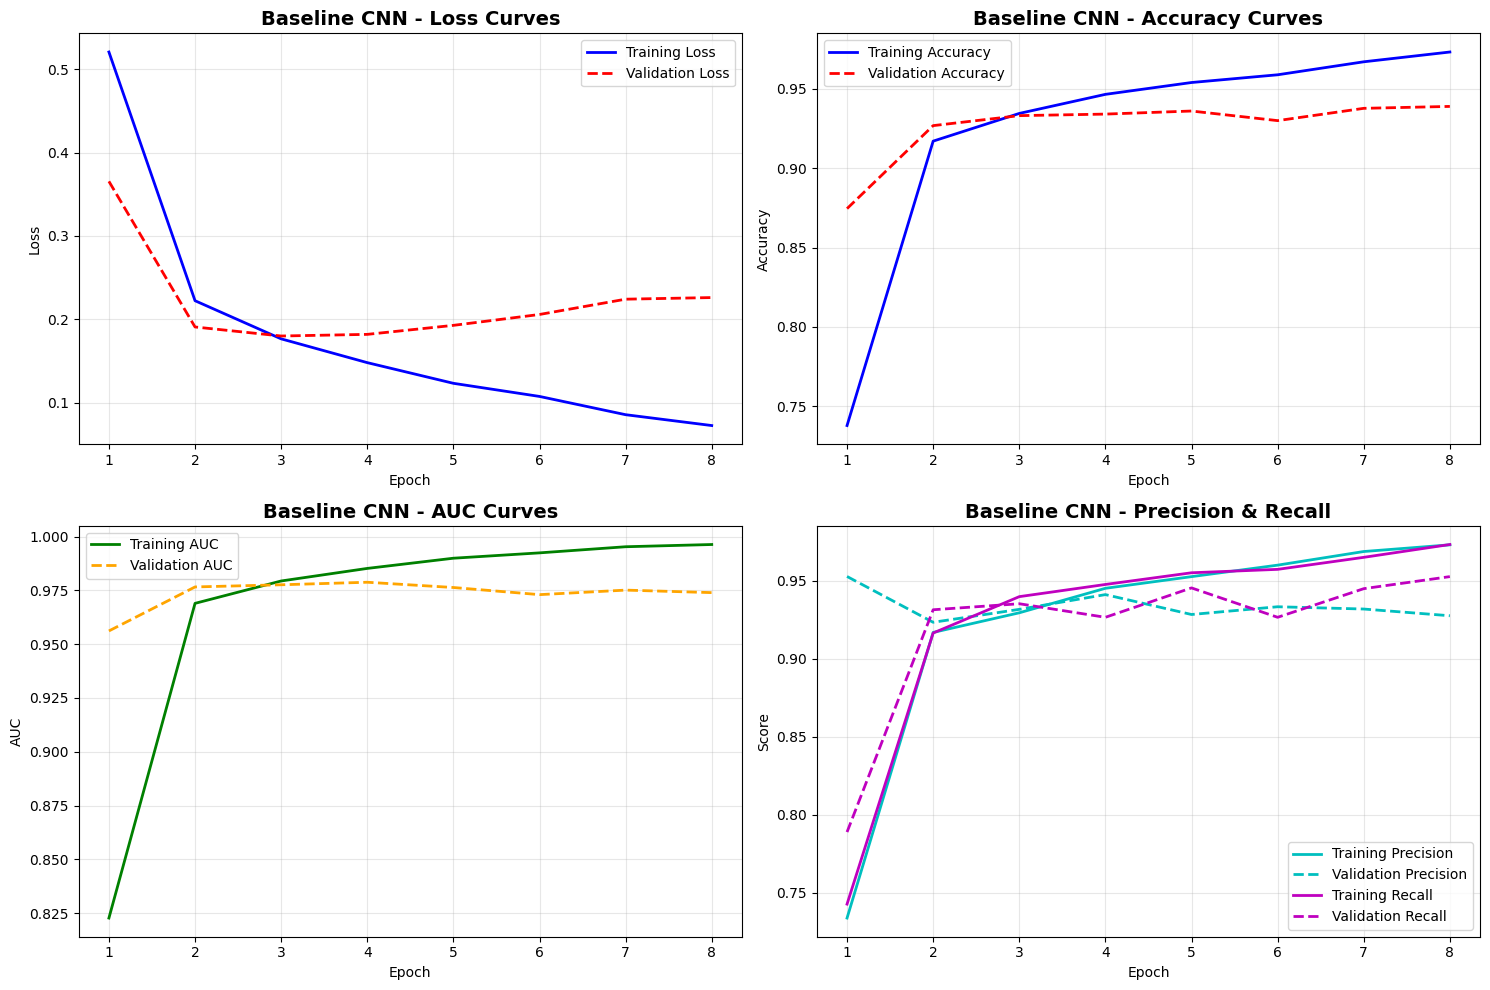

In [54]:
# Learning Curves for Baseline CNN Model
def plot_learning_curves_detailed(history, model_name):
    """Plot comprehensive learning curves with all metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    epochs = range(1, len(history.history['loss']) + 1)

    # Loss curves
    axes[0, 0].plot(epochs, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0, 0].plot(epochs, history.history['val_loss'], 'r--', label='Validation Loss', linewidth=2)
    axes[0, 0].set_title(f'{model_name} - Loss Curves', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy curves
    axes[0, 1].plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    axes[0, 1].plot(epochs, history.history['val_accuracy'], 'r--', label='Validation Accuracy', linewidth=2)
    axes[0, 1].set_title(f'{model_name} - Accuracy Curves', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # AUC curves
    if 'auc' in history.history:
        axes[1, 0].plot(epochs, history.history['auc'], 'g-', label='Training AUC', linewidth=2)
        axes[1, 0].plot(epochs, history.history['val_auc'], 'orange', linestyle='--', label='Validation AUC', linewidth=2)
        axes[1, 0].set_title(f'{model_name} - AUC Curves', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('AUC')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

    # Learning rate (if available)
    if 'lr' in history.history:
        axes[1, 1].plot(epochs, history.history['lr'], 'purple', label='Learning Rate', linewidth=2)
        axes[1, 1].set_title(f'{model_name} - Learning Rate', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    else:
        # If no learning rate, show precision and recall if available
        if 'precision' in history.history and 'recall' in history.history:
            axes[1, 1].plot(epochs, history.history['precision'], 'c-', label='Training Precision', linewidth=2)
            axes[1, 1].plot(epochs, history.history['val_precision'], 'c--', label='Validation Precision', linewidth=2)
            axes[1, 1].plot(epochs, history.history['recall'], 'm-', label='Training Recall', linewidth=2)
            axes[1, 1].plot(epochs, history.history['val_recall'], 'm--', label='Validation Recall', linewidth=2)
            axes[1, 1].set_title(f'{model_name} - Precision & Recall', fontsize=14, fontweight='bold')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Score')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
        else:
            axes[1, 1].text(0.5, 0.5, 'No additional metrics available',
                           ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
            axes[1, 1].set_title(f'{model_name} - Additional Metrics', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot learning curves for baseline model
print("=== BASELINE CNN LEARNING CURVES ===")
plot_learning_curves_detailed(history, "Baseline CNN")


=== EXPERIMENT 2 (E2_AddConvLayer) EVALUATION ===
E2_AddConvLayer Results:
Accuracy:  0.9604 (96.04%)
Precision: 0.9470 (94.70%)
Recall:    0.9760 (97.60%)
F1-Score:  0.9613 (96.13%)
AUC:       0.9888


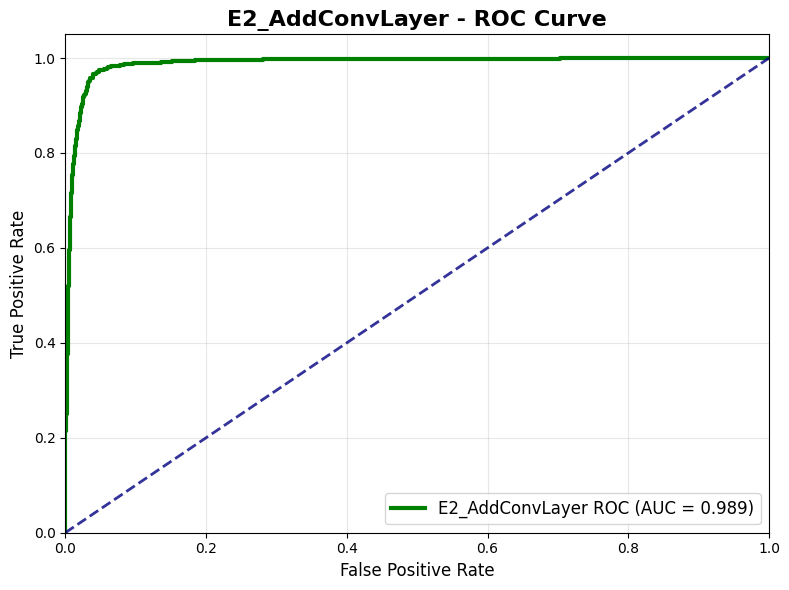

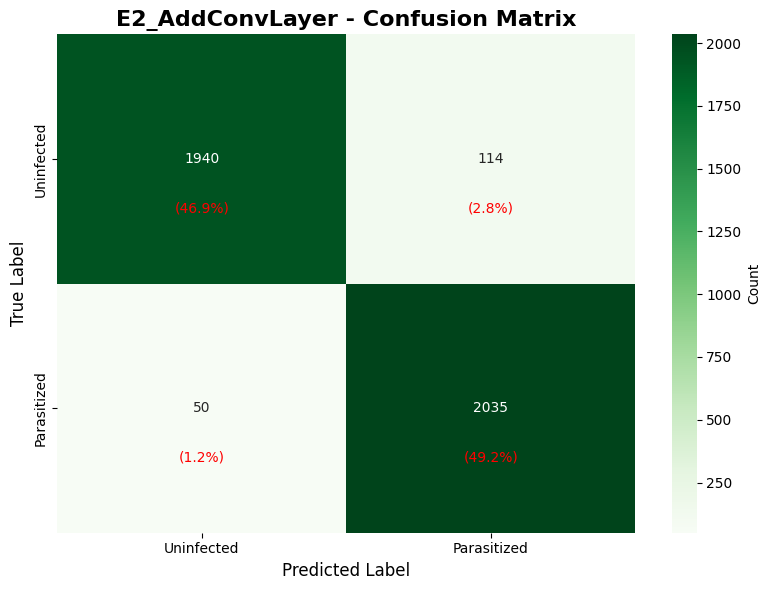

=== E2_AddConvLayer LEARNING CURVES ===


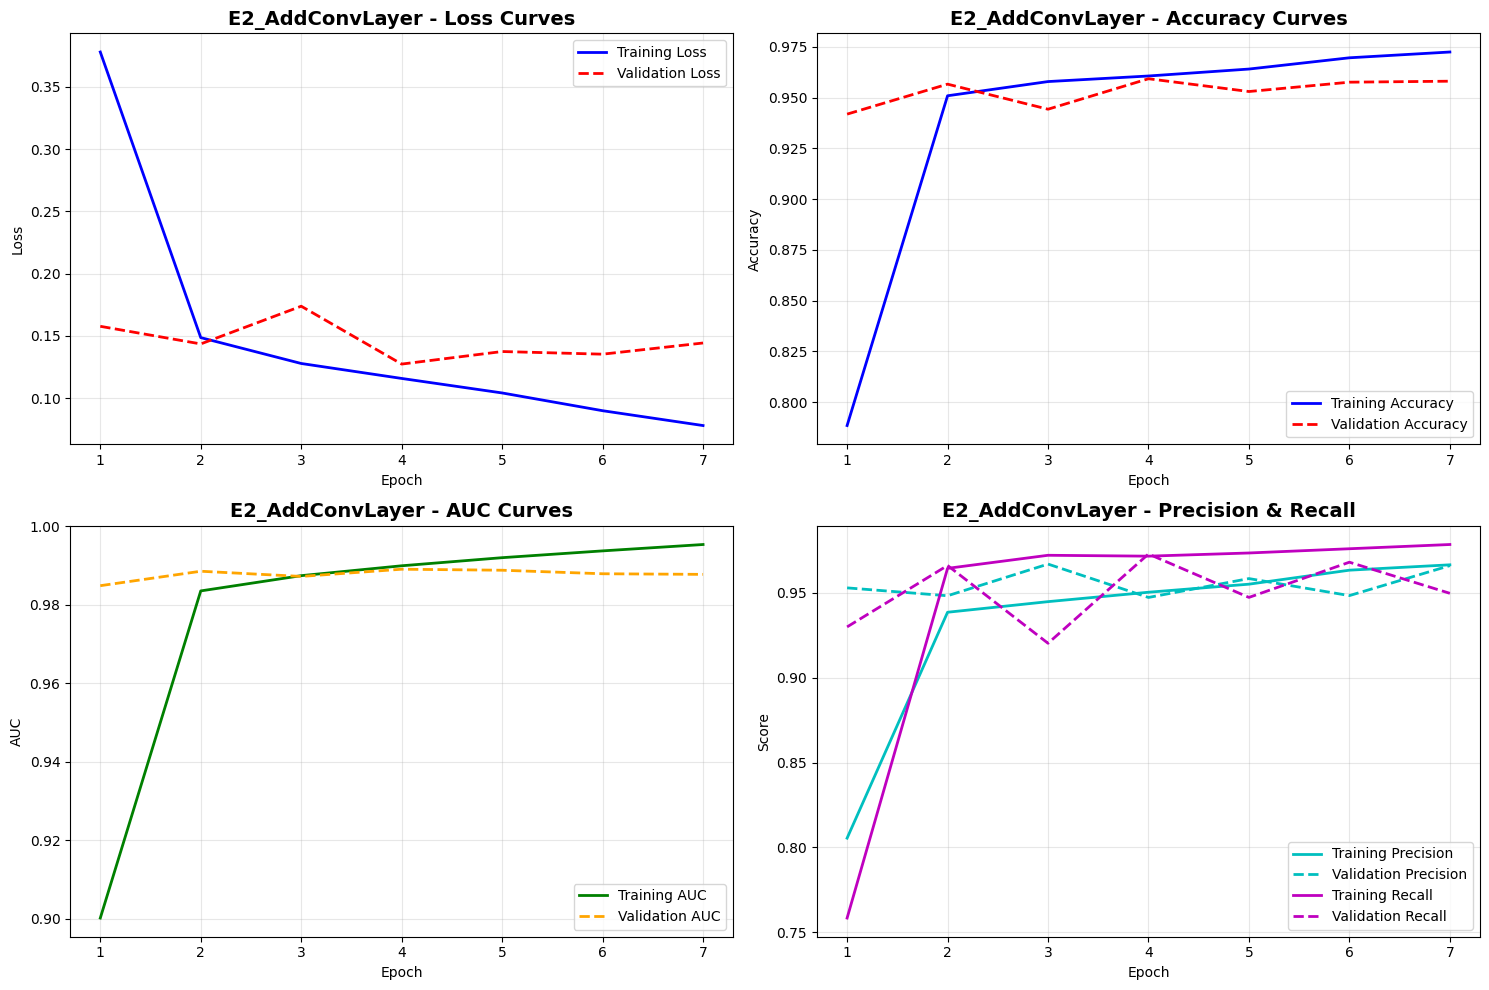

In [55]:
# Experiment 2 (E2_AddConvLayer) Evaluation
print("=== EXPERIMENT 2 (E2_AddConvLayer) EVALUATION ===")

# Get predictions for E2 model
y_pred_proba_e2, y_true_e2 = get_predictions_and_labels(model_E2, ds_test)

# Calculate comprehensive metrics
e2_metrics = calculate_comprehensive_metrics(y_true_e2, y_pred_proba_e2, "E2_AddConvLayer")

print("E2_AddConvLayer Results:")
print(f"Accuracy:  {e2_metrics['Accuracy']:.4f} ({e2_metrics['Accuracy']*100:.2f}%)")
print(f"Precision: {e2_metrics['Precision']:.4f} ({e2_metrics['Precision']*100:.2f}%)")
print(f"Recall:    {e2_metrics['Recall']:.4f} ({e2_metrics['Recall']*100:.2f}%)")
print(f"F1-Score:  {e2_metrics['F1-Score']:.4f} ({e2_metrics['F1-Score']*100:.2f}%)")
print(f"AUC:       {e2_metrics['AUC']:.4f}")

# Plot ROC Curve for E2
y_pred_e2 = (y_pred_proba_e2 > 0.5).astype(int)
fpr_e2, tpr_e2, _ = roc_curve(y_true_e2, y_pred_proba_e2)
auc_e2 = auc(fpr_e2, tpr_e2)

plt.figure(figsize=(8, 6))
plt.plot(fpr_e2, tpr_e2, color='green', lw=3,
         label=f'E2_AddConvLayer ROC (AUC = {auc_e2:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('E2_AddConvLayer - ROC Curve', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('e2_addconvlayer_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion Matrix for E2
cm_e2 = confusion_matrix(y_true_e2, y_pred_e2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_e2, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'],
            cbar_kws={'label': 'Count'})
plt.title('E2_AddConvLayer - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add percentages
total_e2 = cm_e2.sum()
for i in range(cm_e2.shape[0]):
    for j in range(cm_e2.shape[1]):
        plt.text(j+0.5, i+0.7, f'({cm_e2[i,j]/total_e2*100:.1f}%)',
                ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.savefig('e2_addconvlayer_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Learning curves for E2
print("=== E2_AddConvLayer LEARNING CURVES ===")
plot_learning_curves_detailed(history_E2, "E2_AddConvLayer")


=== EXPERIMENT 3 (E3_Dropout) EVALUATION ===
E3_Dropout Results:
Accuracy:  0.9611 (96.11%)
Precision: 0.9616 (96.16%)
Recall:    0.9612 (96.12%)
F1-Score:  0.9614 (96.14%)
AUC:       0.9906


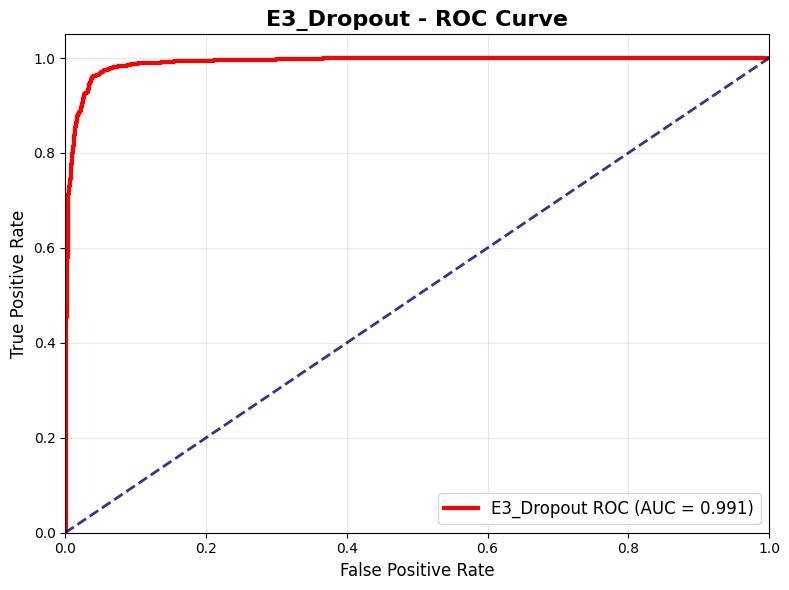

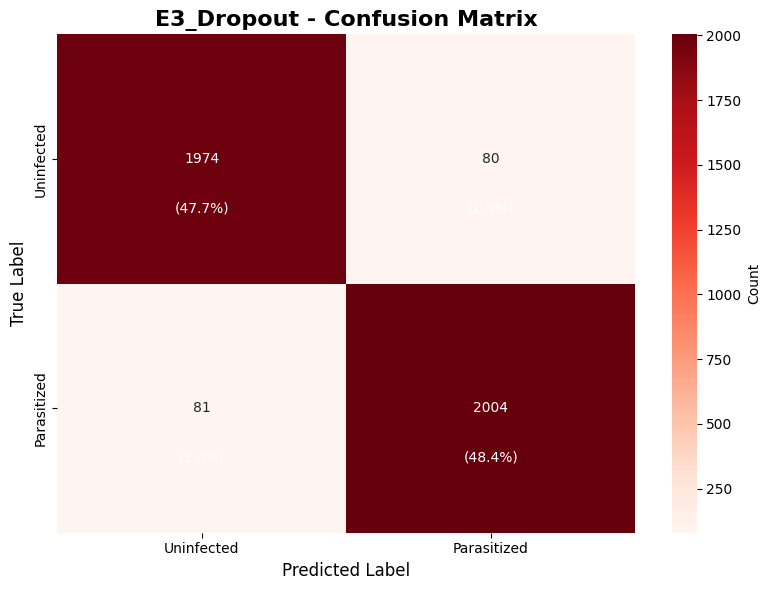

=== E3_Dropout LEARNING CURVES ===


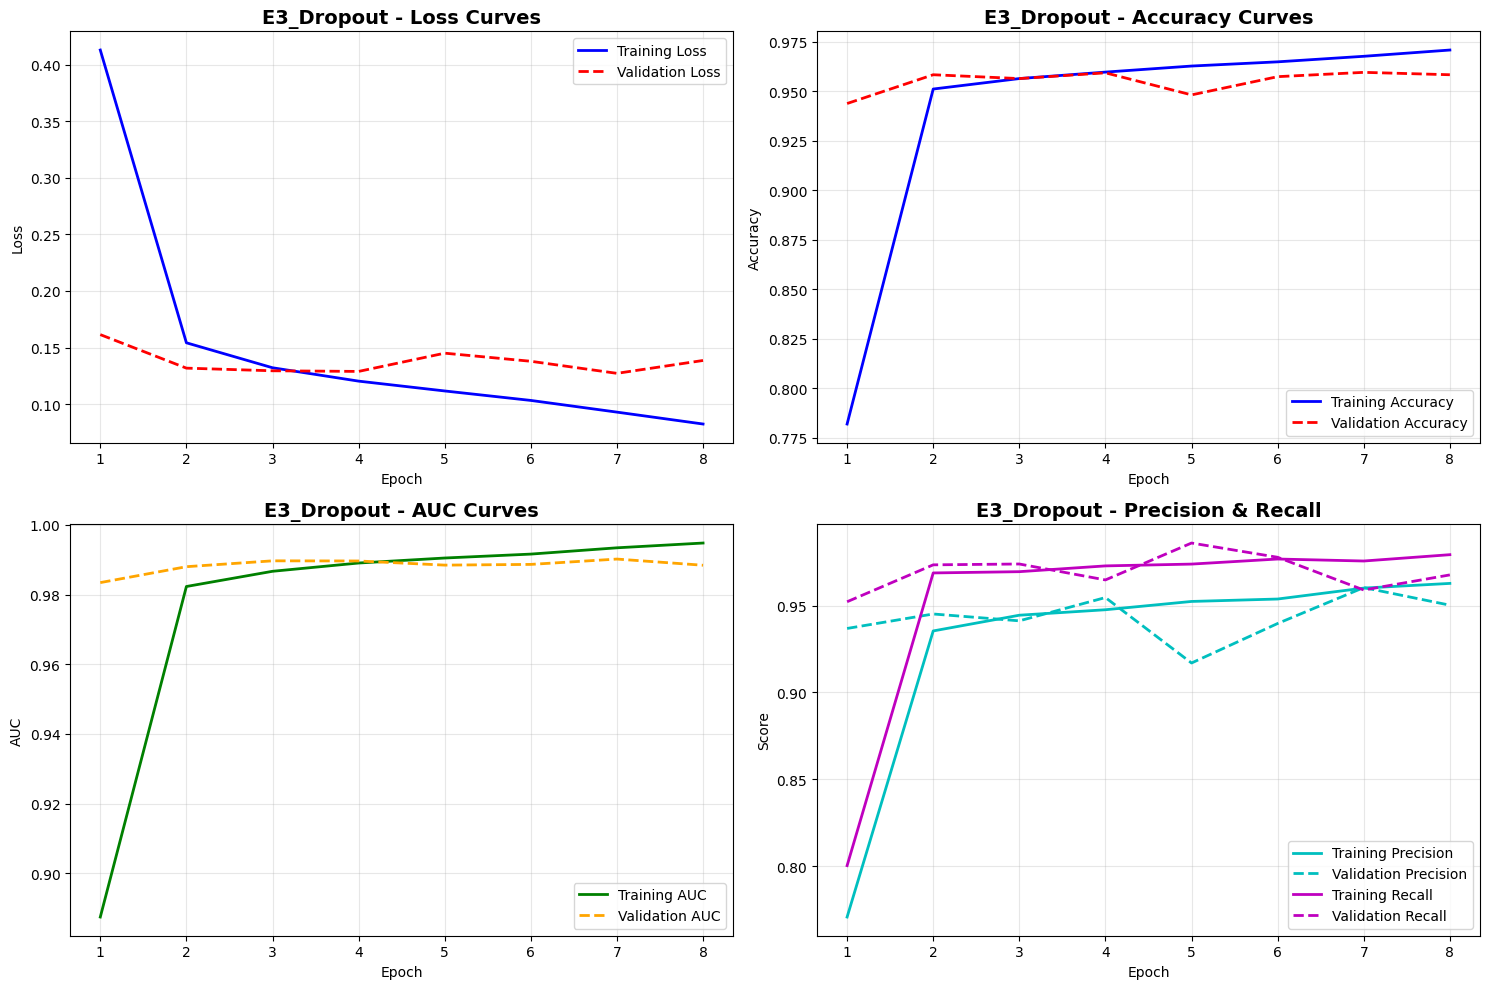

In [56]:
# Experiment 3 (E3_Dropout) Evaluation
print("=== EXPERIMENT 3 (E3_Dropout) EVALUATION ===")

# Get predictions for E3 model
y_pred_proba_e3, y_true_e3 = get_predictions_and_labels(model_E3, ds_test)

# Calculate comprehensive metrics
e3_metrics = calculate_comprehensive_metrics(y_true_e3, y_pred_proba_e3, "E3_Dropout")

print("E3_Dropout Results:")
print(f"Accuracy:  {e3_metrics['Accuracy']:.4f} ({e3_metrics['Accuracy']*100:.2f}%)")
print(f"Precision: {e3_metrics['Precision']:.4f} ({e3_metrics['Precision']*100:.2f}%)")
print(f"Recall:    {e3_metrics['Recall']:.4f} ({e3_metrics['Recall']*100:.2f}%)")
print(f"F1-Score:  {e3_metrics['F1-Score']:.4f} ({e3_metrics['F1-Score']*100:.2f}%)")
print(f"AUC:       {e3_metrics['AUC']:.4f}")

# Plot ROC Curve for E3
y_pred_e3 = (y_pred_proba_e3 > 0.5).astype(int)
fpr_e3, tpr_e3, _ = roc_curve(y_true_e3, y_pred_proba_e3)
auc_e3 = auc(fpr_e3, tpr_e3)

plt.figure(figsize=(8, 6))
plt.plot(fpr_e3, tpr_e3, color='red', lw=3,
         label=f'E3_Dropout ROC (AUC = {auc_e3:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('E3_Dropout - ROC Curve', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('e3_dropout_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion Matrix for E3
cm_e3 = confusion_matrix(y_true_e3, y_pred_e3)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_e3, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'],
            cbar_kws={'label': 'Count'})
plt.title('E3_Dropout - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add percentages
total_e3 = cm_e3.sum()
for i in range(cm_e3.shape[0]):
    for j in range(cm_e3.shape[1]):
        plt.text(j+0.5, i+0.7, f'({cm_e3[i,j]/total_e3*100:.1f}%)',
                ha='center', va='center', fontsize=10, color='white')

plt.tight_layout()
plt.savefig('e3_dropout_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Learning curves for E3
print("=== E3_Dropout LEARNING CURVES ===")
plot_learning_curves_detailed(history_E3, "E3_Dropout")


In [58]:
# Baseline Models Comprehensive Comparison
print("=== BASELINE MODELS COMPREHENSIVE COMPARISON ===")

# Combine only baseline model metrics
baseline_models_metrics = [baseline_metrics, e2_metrics, e3_metrics]
baseline_results_df = pd.DataFrame(baseline_models_metrics)

print("\n📊 BASELINE MODELS RESULTS TABLE:")
print("=" * 80)
print(baseline_results_df.round(4).to_string(index=False))


=== BASELINE MODELS COMPREHENSIVE COMPARISON ===

📊 BASELINE MODELS RESULTS TABLE:
          Model  Accuracy  Precision  Recall  F1-Score    AUC
   Baseline CNN    0.9439     0.9389  0.9506    0.9447 0.9795
E2_AddConvLayer    0.9604     0.9470  0.9760    0.9613 0.9888
     E3_Dropout    0.9611     0.9616  0.9612    0.9614 0.9906


In [59]:
# Final Summary and Analysis
print("=== FINAL BASELINE MODELS ANALYSIS ===")

# Detailed Analysis of Baseline Models
print("\n🔍 DETAILED ANALYSIS:")
print("=" * 40)

print("\n1. BASELINE CNN:")
print(f"   - Simple architecture with 2 Conv2D layers")
print(f"   - Accuracy: {baseline_metrics['Accuracy']:.4f} ({baseline_metrics['Accuracy']*100:.2f}%)")
print(f"   - Recall: {baseline_metrics['Recall']:.4f} (Critical for medical diagnosis)")
print(f"   - AUC: {baseline_metrics['AUC']:.4f}")

print("\n2. E2_ADD CONV LAYER:")
print(f"   - Enhanced with additional Conv2D layer")
print(f"   - Accuracy: {e2_metrics['Accuracy']:.4f} ({e2_metrics['Accuracy']*100:.2f}%)")
print(f"   - Recall: {e2_metrics['Recall']:.4f}")
print(f"   - AUC: {e2_metrics['AUC']:.4f}")

print("\n3. E3_DROPOUT:")
print(f"   - Added dropout for regularization")
print(f"   - Accuracy: {e3_metrics['Accuracy']:.4f} ({e3_metrics['Accuracy']*100:.2f}%)")
print(f"   - Recall: {e3_metrics['Recall']:.4f}")
print(f"   - AUC: {e3_metrics['AUC']:.4f}")

# Medical Diagnosis Insights
print("\n🏥 MEDICAL DIAGNOSIS INSIGHTS:")
print("=" * 40)
print("For malaria diagnosis, RECALL is the most critical metric:")
print("- High Recall = Fewer missed malaria cases (False Negatives)")
print("- This is crucial to avoid missing infected patients")

best_recall_model = max([baseline_metrics, e2_metrics, e3_metrics], key=lambda x: x['Recall'])
print(f"\n🎯 BEST RECALL: {best_recall_model['Model']} ({best_recall_model['Recall']:.4f})")

# Summary Table
print("\n📋 SUMMARY TABLE:")
print("=" * 80)
summary_data = {
    'Model': ['Baseline CNN', 'E2_AddConvLayer', 'E3_Dropout'],
    'Architecture': ['2 Conv2D + 2 Dense', '3 Conv2D + 2 Dense', '3 Conv2D + 2 Dense + Dropout'],
    'Accuracy': [baseline_metrics['Accuracy'], e2_metrics['Accuracy'], e3_metrics['Accuracy']],
    'Precision': [baseline_metrics['Precision'], e2_metrics['Precision'], e3_metrics['Precision']],
    'Recall': [baseline_metrics['Recall'], e2_metrics['Recall'], e3_metrics['Recall']],
    'F1-Score': [baseline_metrics['F1-Score'], e2_metrics['F1-Score'], e3_metrics['F1-Score']],
    'AUC': [baseline_metrics['AUC'], e2_metrics['AUC'], e3_metrics['AUC']]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.round(4).to_string(index=False))

print("\n✅ Baseline models evaluation and analysis completed!")


=== FINAL BASELINE MODELS ANALYSIS ===

🔍 DETAILED ANALYSIS:

1. BASELINE CNN:
   - Simple architecture with 2 Conv2D layers
   - Accuracy: 0.9439 (94.39%)
   - Recall: 0.9506 (Critical for medical diagnosis)
   - AUC: 0.9795

2. E2_ADD CONV LAYER:
   - Enhanced with additional Conv2D layer
   - Accuracy: 0.9604 (96.04%)
   - Recall: 0.9760
   - AUC: 0.9888

3. E3_DROPOUT:
   - Added dropout for regularization
   - Accuracy: 0.9611 (96.11%)
   - Recall: 0.9612
   - AUC: 0.9906

🏥 MEDICAL DIAGNOSIS INSIGHTS:
For malaria diagnosis, RECALL is the most critical metric:
- High Recall = Fewer missed malaria cases (False Negatives)
- This is crucial to avoid missing infected patients

🎯 BEST RECALL: E2_AddConvLayer (0.9760)

📋 SUMMARY TABLE:
          Model                 Architecture  Accuracy  Precision  Recall  F1-Score    AUC
   Baseline CNN           2 Conv2D + 2 Dense    0.9439     0.9389  0.9506    0.9447 0.9795
E2_AddConvLayer           3 Conv2D + 2 Dense    0.9604     0.9470  0.9760